In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 1/20, Loss: 11.374531123396341, Accuracy: 0.3752
Epoch 2/20, Loss: 6.1444699209324165, Accuracy: 0.3801
Epoch 3/20, Loss: 6.106682408604318, Accuracy: 0.4339
Epoch 4/20, Loss: 4.946113395162589, Accuracy: 0.4160
Epoch 5/20, Loss: 5.860545625987978, Accuracy: 0.4127
Epoch 6/20, Loss: 3.6890651678859996, Accuracy: 0.4372
Epoch 7/20, Loss: 3.735080325735624, Accuracy: 0.4568
Epoch 8/20, Loss: 3.9451948602006515, Accuracy: 0.4551
Epoch 9/20, Loss: 3.164556801911782, Accuracy: 0.4486
Epoch 10/20, Loss: 2.8779235596174386, Accuracy: 0.4731
Epoch 11/20, Loss: 3.068286831929143, Accuracy: 0.4845
Epoch 12/20, Loss: 2.379774319056373, Accuracy: 0.4927
Epoch 13/20, Loss: 2.2701121881217152, Accuracy: 0.4698
Epoch 14/20, Loss: 1.6225331199851323, Accuracy: 0.5302
Epoch 15/20, Loss: 1.9665577843824595, Accuracy: 0.4796
Epoch 16/20, Loss: 1.8035722809613912, Accuracy: 0.5057
Epoch 17/20, Loss: 1.5652187388487064, Accuracy: 0.4763
Epoch 18/20, Loss: 1.3950591996892707, Accuracy: 0.5090
Epoch 19

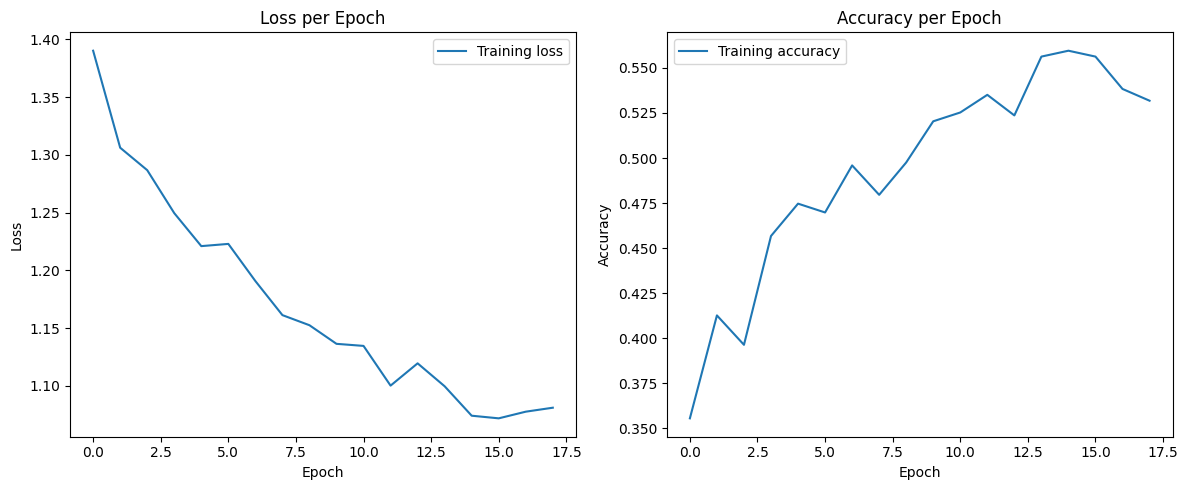

In [11]:
import torch
from torch import nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim

# Define the model
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.residual_block = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(64 * 28 * 28, 4)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        identity = x
        x = self.residual_block(x)
        x += identity
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Data transformations with augmentation for training
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Data transformation without augmentation for testing
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Data loading
train_dataset = datasets.ImageFolder('drive/MyDrive/train', transform=train_transform)
test_dataset = datasets.ImageFolder('drive/MyDrive/test', transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Instantiate the model
model = EnhancedCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.002)

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Accuracy: {train_accuracy:.4f}")


all_test_preds = []
all_test_labels = []
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

test_accuracy = correct / total
print(f'Accuracy on test images: {test_accuracy * 100:.2f}%')

# Plot the charts
plt.figure(figsize=(12, 5))

# Plot the training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()